In [1]:
%config InlineBackend.figure_format = 'retina'
# %matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sg
from PIL import Image

np.random.seed(1234)

## Parameters

In [24]:
alphabet = np.array([1 + 1j, 1 - 1j, -1 + 1j, -1 - 1j]) / np.sqrt(2)

K = 1024
B = 3e3
f0 = 15e3
fc = f0 + B / 2
fs = 48000
is_cp = True

n_sps = int(fs / B)

n_blk = 4
t_pause = 64e-3
t_guard = 32e-3
ns_pause = int(t_pause * fs)
ns_guard = int(t_guard * fs)
n_sps = int(fs / B)

n_bits = 7

ns_blk = ns_guard + n_sps * K
ns_ofdm = ns_blk * n_blk
ns_frame = (2**n_bits - 1) * n_sps + ns_pause + ns_ofdm
Ns = int(n_sps * K)
Ng = ns_guard
Nb = Ng + Ns

## Root raised cosine filter

Text(0.5, 0, 'Time [ms]')

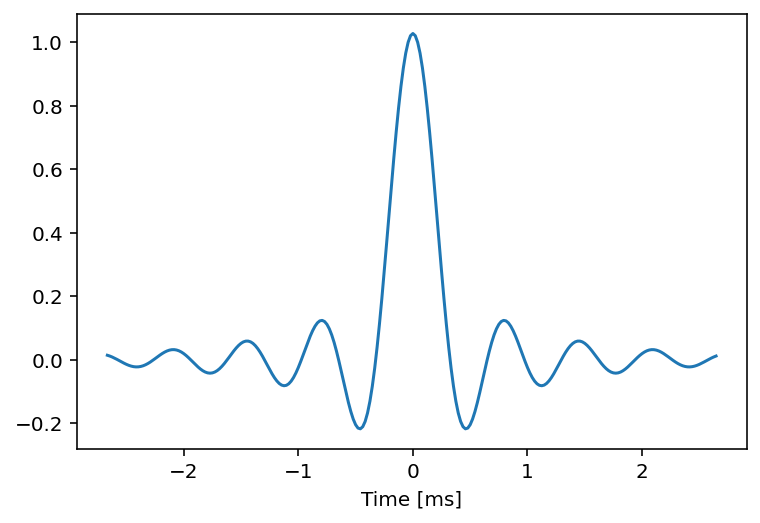

In [25]:
def rrcosfilter(N, alpha, Ts, Fs):
    T_delta = 1 / float(Fs)
    time_idx = ((np.arange(N) - N / 2)) * T_delta
    sample_num = np.arange(N)
    h_rrc = np.zeros(N, dtype=float)

    for x in sample_num:
        t = (x - N / 2) * T_delta
        if t == 0.0:
            h_rrc[x] = 1.0 - alpha + (4 * alpha / np.pi)
        elif alpha != 0 and t == Ts / (4 * alpha):
            h_rrc[x] = (alpha / np.sqrt(2)) * (
                ((1 + 2 / np.pi) * (np.sin(np.pi / (4 * alpha))))
                + ((1 - 2 / np.pi) * (np.cos(np.pi / (4 * alpha))))
            )
        elif alpha != 0 and t == -Ts / (4 * alpha):
            h_rrc[x] = (alpha / np.sqrt(2)) * (
                ((1 + 2 / np.pi) * (np.sin(np.pi / (4 * alpha))))
                + ((1 - 2 / np.pi) * (np.cos(np.pi / (4 * alpha))))
            )
        else:
            h_rrc[x] = (
                np.sin(np.pi * t * (1 - alpha) / Ts)
                + 4 * alpha * (t / Ts) * np.cos(np.pi * t * (1 + alpha) / Ts)
            ) / (np.pi * t * (1 - (4 * alpha * t / Ts) * (4 * alpha * t / Ts)) / Ts)

    return time_idx, h_rrc


def upsample(s, n, phase=0):
    return np.roll(np.kron(s, np.r_[1, np.zeros(n - 1)]), phase)


time_idx, rc_tx = rrcosfilter(16 * int(1 / B * fs), 0.1, 1 / B, fs)
plt.plot(time_idx * 1e3, rc_tx)
# plt.plot(np.arange(-3, 3)/B*1e3, np.zeros(6), 'x')
plt.xlabel("Time [ms]")

(0.0, 600.0)

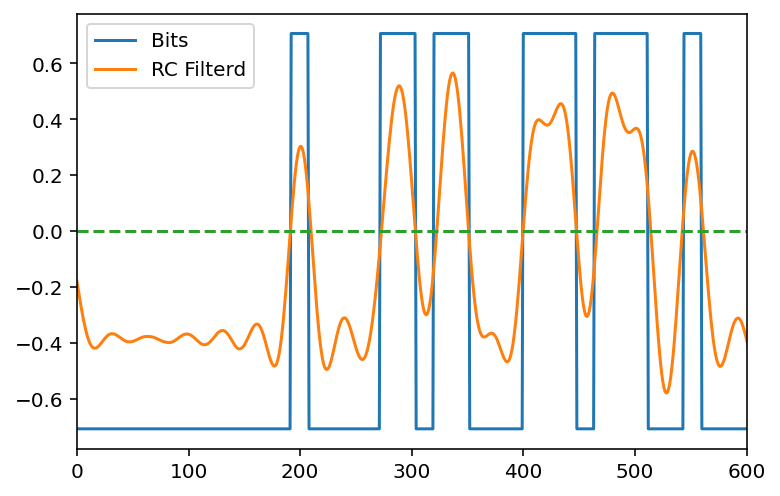

In [26]:
def gold_preferred_poly(nBits):
    return {
        5: (np.array([5, 2, 0]), np.array([5, 4, 3, 2, 0])),
        6: (np.array([6, 1, 0]), np.array([6, 5, 2, 1, 0])),
        7: (np.array([7, 3, 0]), np.array([7, 3, 2, 1, 0])),
        9: (np.array([9, 4, 0]), np.array([9, 6, 4, 3, 0])),
        10: (np.array([10, 3, 0]), np.array([10, 8, 3, 2, 0])),
        11: (np.array([11, 2, 0]), np.array([11, 8, 5, 2, 0])),
    }[nBits]


def generate_gold_sequence(
    nBits, index=0, poly1=None, poly2=None, state1=None, state2=None
):
    from scipy.signal import max_len_seq as mls

    if (poly1 and poly2) is None:
        poly1, poly2 = gold_preferred_poly(nBits)
    return np.bitwise_xor(
        mls(nBits, taps=poly1, state=state1)[0],
        np.roll(mls(nBits, taps=poly2, state=state2)[0], -index),
    )


sequence = (1 + 1j) / np.sqrt(2) * (generate_gold_sequence(n_bits, index=0) * 2 - 1)
upsampled = np.repeat(sequence, n_sps)
preamble = sg.convolve(upsampled, rc_tx, mode="same")
preamble /= np.max(np.abs(preamble))
# preamble_xcorr = sg.convolve(upsample(preamble, n_sps), rc_tx, mode="same")

plt.figure()
plt.plot(upsampled.real, label="Bits")
plt.plot(preamble.real, label="RC Filterd")
plt.axhline(0, ls='--', c='C2')
plt.legend()
plt.xlim([0, 600])

## Prepare the image

In [27]:
import base64
from io import BytesIO

data = """/9j/4AAQSkZJRgABAQABCAEIAAD/4QCYRXhpZgAATU0AKgAAAAgABgEGAAMAAAABAAIAAAESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAIdpAAQAAAABAAAAZgAAAAAAAAEIAAAAAQAAAQgAAAABAAOgAQADAAAAAQABAACgAgAEAAAAAQAAAR6gAwAEAAAAAQAAAQYAAAAA/8AAEQgBBgEeAwEiAAIRAQMRAf/EAB8AAAEFAQEBAQEBAAAAAAAAAAABAgMEBQYHCAkKC//EALUQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+v/EAB8BAAMBAQEBAQEBAQEAAAAAAAABAgMEBQYHCAkKC//EALURAAIBAgQEAwQHBQQEAAECdwABAgMRBAUhMQYSQVEHYXETIjKBCBRCkaGxwQkjM1LwFWJy0QoWJDThJfEXGBkaJicoKSo1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoKDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uLj5OXm5+jp6vLz9PX29/j5+v/bAEMAAQEBAQEBAgEBAgMCAgIDBAMDAwMEBQQEBAQEBQYFBQUFBQUGBgYGBgYGBgcHBwcHBwgICAgICQkJCQkJCQkJCf/bAEMBAQEBAgICBAICBAkGBQYJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCf/dAAQAEv/aAAwDAQACEQMRAD8A/v4ooooAKKKKACiiigAooooAKKKKAPjL9uf9s74Rf8E/v2V/Fn7V3xplI0bwvb+ZHaRMqz395M3lW9nBv/5azysq/wCx8zt8isa/x/v+Cin/AAVM/a3/AOClnxd1L4kftA+JLptJmnZtM8NWs0kekaXBuJjht7cNsZkGN0zgyyMNzNjAr+of/g9L/bA1jWPiv8Mv2GvD94V0vRNPk8X6zChbbJeXkklpYLL/ALUMEUzJ/wBd6/hPJyc0AfpZ+yL/AMFdP+Chv7DusWl9+zv8VNd0zT7VlJ0a9uX1DSJVX+F7G6MkAyOCUVGH8LLX+lP/AMEGf+C5Xh//AIK4fDjWvC3xC0iDwx8V/BMUE+s2Nm7GxvbWZvLW+svMZ5I08xdk0Du3lM0f7xxJ8v8AkV19M/sx/te/tJ/sYeP5Pil+y7411TwTr81sbKa70uURtNbM6SmGZWDJLGXjRijqy5UUAf7r9Ff5aP7L/wDwd/8A/BTP4NSwWHx4s/DvxY0xdole+tRpeouqf3LrTxHFn3ktXr+un/gnR/wc2f8ABPD9v3W7H4Y+JL6f4T+O750ig0jxLJCtpdzP92Oy1Jf3MrbiqosqW8rt9xGoA/pFopqtup1ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//Q/v4ooooAKKKKACiiigAooooAKjYiNS1SVGwEilaAP8hP/g5/8c3/AI2/4LWfGG2nY+ToQ0TTIF7COHSLNiP+/kjn8a/n3r+jn/g6k+CPiL4Sf8FlPiH4m1SB47Dx5ZaRr+mu64EsRsYbKYqe+25tZRX841ABRV6S1mjCvINu8blz6Zxn259arlGC7j0/z2oAVHcAgHGeo9cc81ZhE88qwRgu8hCKAOSTgAD9P5Vn0UAf6SX/AAaYf8Fcvit+0voGvf8ABP79ozVpNe1zwPpK6v4X1S8kaS6m0dJI4JrGaR/mk+xvLC0LNufynZPuRpX9s1f5In/Bqb4vm8Mf8FqfhvpUcnlx6/pniHT5QP41GlXFyo/F4F/Kv9blPu0AOooooAKKKKACiiigAooooAKKKKACvzw/4KO/8FOv2U/+CW/wWHxn/ae1aWM3ztb6Rounqk2qarcIAWjtYGdFIQEGSWR0ijBG5gWUN+h9f49n/BxR/wAFGL7/AIKI/wDBR/xPf+H5g/gj4cyz+FPDSxsWjnhs53W4vhyQTdzhnUgD9yIgRlSSAfrR+15/weifth+Pdbm0r9jTwJofw+0NflS81sNrOqyEfx4DQ2kIP/PMxTY/56Gvz28M/wDB11/wWj0T4m6b4+1r4gaZrOnWTL5+g3OhabHp95GDlklNvBFdLu/vxXCMOxAyD/N4Rg4607IxjH40Af6oH/BLb/g64/ZJ/bz+KGn/ALP/AMe/Dsnwa8aa1KtvpEl3fpf6NqFw2Alut6YrZre4lYkRRzRbHOEWYysiN/VoCCMiv8AtWZGDKcEcgiv9X/8A4NY/+Cl/jf8Ab3/YSvvhr8aNQk1bx18H7u30a7v52Lz3umXMbPptxO55aUCKaB2OS3kh2JZyaAP6dqKKKAP/0f7+KKKKACiiigAooooAKKKKACiiigD8if8Agq9/wR6/Zg/4K1fC6w8IfGpbnQ/Eugea+heJtMWM3lkZseZC6yfJcW0jKrPC23puR43+av48PHH/AAZLftbWGqPB8MvjN4Q1SxB+SbVLPUNPmK/7UUK3if8Aj9f6QtFAH8Ev7Ff/AAZkzeC/jFo3jz9tj4mab4g8P6Rcx3U/h7w7aThdR8lgwhmvbvZ5cD4CzLHBvdNyo0f3q/R7/g4A/wCCUn/BLfwj/wAE5/ix+1Mvwn0Lwn4u8LaT9p0jVPDkC6O41GaaK1tlmitNlvcq8sqq6yxv8v3NrYav6vK/jf8A+DzH9qC2+HX7Bvgz9mTTJwupfErxIt1cRbuW03Q4/PlyP+vuW1/75NAH+ZZIu2Qqf0qKipGVlOT6Z/OgD+gP/g170+bUP+C3fwYMQ4gGvSHHomiXxP8AOv8AXvT7tf5N3/BpX4f/ALW/4LLeEdUxkaR4e8QXZ9s2TW+f/I1f6ydABRRRQAUUUUAFFFFABRRRQAUUUUAFf4JvxXu7a5+K3iS/0yE2kL6tePFESSYlM7lVJPOVHH4V/vZV/jc/8F7/APgnN4+/4J4f8FDfGuh3umzR+BvG+pXniHwnqGw/Z57K8lM72qv082ykk8iRThsBHwFkQkA/E2iirKQGRS+VAXGckA8+g6n8AaAK1f3g/wDBjrLcL8Tv2iYAT5R0vw2xHbcJtQx+hNfwnWNje6new6ZpsL3FxcOsUUUSl3d3OFVVAJLEnAAGSa/1ff8Ag2E/4JR+PP8Agm/+x/q3xD+PFmdO+I3xamtNRv8AT3GJdN061jf7DZzA8rcfvpZZl/gLiMjdGSQD+muiiigD/9L+/iiiigAooooAKKKKACiiigAopOAK/h//AODiH/g5D+K37IHxh1H9hX9gy5ttP8V6NDGPE3iqaOO8exnuY1lSwsIZd8QmSJlaaeVJdjN5SIrqzKAf28SSxRr5jttHXJ6VxFz8UPhxZS/Z7rxBpsUn9x7uFW/9Cr/Ds+NH7bH7X37Rmq3Gs/Hj4m+KPF09y25v7V1a7uUX0CRSSmNFAOFVVCqOgFfMLXEjuXkO5m6k8/zoA/3zNN8VeHNbX/iSahbXn/XCaOT/ANBav8ov/g6u/bCT9pz/AIKq+Ifh7oNyZtB+EljD4TtlUjyzexk3OpPgcbxczGB/+vda/m60vxFr+iTC40a9ntJB0aGRkP8A46RUN9f3Op3MuoalI89xO7SSSSEszs3JZmJyzE5JJ5J5JOaAMwYJ5pKKU4/hoA/r2/4MwfBcmuf8FOfGXi0j93ofw81Bs/8ATS51DT4l/wDHd9f6gNf5Av8AwQK/4K/fCn/gkN8ZfGvxE+KHgrUvF0HjDS7XSxJpdzDBPZxwTmeRgk67Zd52/L5ifdr+7D9nP/g6r/4JAfHye307xD4x1T4c30/3IPFemyW8Yb+693aNeWi/7zzJQB/SVRXjnwh+OvwZ+P8A4Qj8c/AvxXo/jHRJeF1DRL63v7f/AHfMt2dN3+zXsdABRRRQAUUUUAFFZuo6jYaPYT6tqsyW9taxtNNNKwRI40BZnZjgBVAJJPAFfxdftX/8Hpf7Lnwm+J1/4F/Zi+FWqfE/S9Nmkt31y71WPQ7W4eNivmWkYtL6WWBuqvKsLH+5jBIB/avRX8+n/BHD/g4S/Zp/4K16tffCe30a58AfEzTbVr59BvZ0uYby1QgSS2F0qx+d5WV82N443UHcAyhiv9BdABXyp+2F+xZ+zN+3r8Grv4C/tUeFrbxT4duXE0ccpaOe1uFBVLi1uIyssEyhiA6MCVJU5ViD9V0UAf54f7X/APwZQ/FCz8SXet/sJ/FTTNQ0aRi8Ok+M1ltbuBeyC+sYJ45z6FreD3z1r4q8H/8ABmT/AMFSda8Q29h4u8T+ANF052/fXY1K+uWjXvthSwUu3oCyg92Ff6iNFAH83v8AwSb/AODaf9jP/gmd4hsfjT4rupfil8UrMbrfW9Tt1gs9OkIwW06wDSLFJzjzpZJZR/AYwWB/pCoooAKKKKAP/9P+/iiiigAooooAKKKKACiiigDwr9or42eF/wBm34C+Mv2gPG7BdJ8E6Jf63ec43R2Vu07KP9p9u1frX+Gr8bfit41+Pfxd8UfHH4i3Bu9c8X6teaxqEzEndc3szzSH5iTjcxAGeg9q/wBR7/g7O/aZ/wCFDf8ABJjWfh1pdyINS+Kmuaf4bQJ9/wCyozajdt/umO2ET/8AXX/ar/KRll805xjHAAzgAfUmgCtS4OcUlFABRRRQAuDjNJTgSpyOopzMW647DigCOlBI6UlFAH0l+y/+1v8AtG/safE22+MH7MvjDU/B2vWjK3n6fO0aTKh3CO5h5iuISfvRTI8bdCvNf67v/BE7/gqFoH/BVf8AYr0z45zx2+n+NNFm/sbxZpltlUt9SiVW86FGZ3FtdRMs0O77mXi3MY2av8ZCv6Z/+DV39vub9j7/AIKU6V8HvFN+bbwd8Z0Tw1eIzbYk1QsW0mcgkAt55NsDngXLHtQB/rI0U1W3DNOoAKKKKAPw8/4OPPjL49+Bf/BGD43+LvhwXiv9Q06y0Ka4TH7mz1vULbTbxjnn57e4kiBHIZwR0r/HKr/cm/4KHfsfaD+3x+xV8Rf2Q/Ed5/Z0XjbSjbQXm3eLa8hkS5s52TI3LFcwxOy5G4AjIzX+Q/8AtH/8EYP+Cn/7MHxRv/hX45+CnivVJrSdooNR0DSrzVtNvUBwsttd2kUkbq4wwVtsi5w6I2VABS/4IveOfFvw9/4Kz/s5a74KuZLS7ufiFoGmSvGSC1pqd9FY3kZx/DJbTyo3+yTX+1/X+ff/AMG23/Bul+0L8Nfj/wCHv+Cg/wC3bob+ELfwoz3XhbwrfoBqU980bJHfX0JGbWO33l4YnxO0yq7LGiDzf9BCgAooooAKKKKACiiigAooooA//9T+/iiiigAooooAKKKKACiio2IjUtQB/nMf8HsX7QDa9+0J8G/2YbKcGPw5oN94ju4kPWXVbn7LDu/2kjsH/wC+6/h7eGWM/vFK8kcjHI6/lX77/wDBzL8a5PjT/wAFl/i4YZhJY+FpNP8ADdsQc7Bp1lEs646jFy8+QODkmvwJlmluJmmnYu7kksxyST1JJ60AVaKKKACrc0RilaNsEqSCVII49COCPcVUooAKKKcw7+tADaKKKACug8M+Itb8H+I9P8V+Gbl7PUtMuYru0uIzh4p4XDxyKezKwBB7EVz9FAH+5x+wX+05pn7Zf7Gfwz/ai0oIP+E28PWOpXEafdhvHj23cP8A2xuVkj/4DX2BX8gn/Bmz+02fin/wTt8T/s66rceZffC3xLMLePO7Zputr9sh/wDJpbuv6+6ACivxI/4KF/8ABwL/AME4P+CanxOj+Cnx01/UdZ8YiNJrvR/Ddot/cWEco3Rm8Z5YYYWdSGWIyGXYVfYFZSf0C/Yt/bb/AGbf+CgfwLsf2iv2WvEKa/4bvJXtpCUaG5tLqIAy2t3A+HhmQMrFWHKsrqWRlYgH1rRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//1f7+KKKKACiiigAor53/AGg/2mf2fP2U/AUnxM/aT8Z6P4K0GIsv2zV7qO1jdv8AnnFvbfNL/wBM4wzt/dr+UT9s7/g8w/Y/+F0134X/AGNPBeq/E+/iJjj1XUm/sXSc9pIlZXvZl/2Xht/96gD+0B2VR8xxWXe31rpdtJe30qwQwje8kh2oi9yWav8AJs/aZ/4Orv8Agrt+0E89j4R8Wab8MtMmyDa+FtPjilCg/L/pl6bu5DD+9HJHX4g/Gb9rv9qf9oq9k1H48/EjxN4xllJZjrOrXd8Mk5OFnldVHoqgKOgAoA0P2y/i3L8eP2tfif8AG2WUz/8ACX+K9Z1cO3OVvL2aVAG5yArivl+r8d3PErpE7qsq7HAJAZcjg4PIyAcHPIFe7/Az9k79qT9p86mP2avhr4q+IZ0Xyf7QHhnRr3Vvsn2jf5P2j7HDL5XmeXJs343bGxnBoA+eaK+8NY/4Jdf8FL/Dtot/4h/Z4+JdjC52q9x4U1eJSfQFrUc1yE//AAT8/bzt4Xubr4JePoo4wWZm8NaoFUDkkk2+ABQB8fUV6X4n+EHxZ8FWz3njTwtq+kRRv5bPe2M9uqv/AHSZEUA+3WvNKAHqBnBplFFABRRTlUmgBtFFKQR1oA/sD/4MzP2gpPh9/wAFEfGHwGvpNtn8Q/CUzxpuxvvtGmS4h4/2beS6Nf6elf4uH/BC340n4Af8FcPgL8QZJjbwTeK7XR5pM4UQ60G0yTd/s7Lo5r/aMj+4KAP8OX/gpLL8RZv+ChPxvl+LYuF8SHx1r/28XIIkEn9oTcYP8O3GzHy7MbflxX9gP/Bj6vxMPiz9oB42uP8AhDRaaEHUk/Z/7TMl3sKA8eZ5Abfjnbs3fw1/Tv8At8f8EBv+Caf/AAUZ+KH/AAu749+Eryy8YzJHFeaxoN7JYXF7HCoSMXSAPDKyKAokMfm7Qq79qgD7+/ZA/Yx/Zr/YP+C9j8AP2V/C9v4W8NWbtM0URaSa5uHAD3F1PIWlnmcAAvIxIUKowqqoAPqeiviD9s//AIKFfsg/8E/vh6PiP+1d430/wraTBvsdtKxl1C9ZPvLaWUQa4uCDt37E2pn52Wv45f2tv+D1tYrq40X9h34SLLChYRax40uGXf7/ANm6e/Hr817/AMBoA/v3LBRzTd8X94fnX+Rv8W/+Dp//AILOfE+5kOlfEex8IW0hz9n0HRtPhCj0EtxDcXH/AJGr5F1H/gvD/wAFf9VnNxc/tCeMUY9ob0Qr/wB8xqooA/2ghIjD5CDUlf44HgD/AIOLf+CzXw7v473SPjxrV6Iz/q9Vt7HUY2Hut1bSfzr9gP2ZP+Dzf9tzwDqUNh+1F4D8N/EHSVYedPpol0XUmBON4kRp7Un/AGfsyf71AH+l/RX44f8ABNT/AILc/sMf8FRrP+w/gXrk2j+NreEz3fhLXVjtNVSNP9ZJAFZ4ruJP42t3fZ8vmrHur9j6ACiiigAooooA/9b+/iiivOfiT8Svh/8ABvwFrHxT+KGrWug+HfD9rJfajqN7IIoLa3iXdJJI7fdVVoA3tc1vR/DmkXeveILyGysrGGS4uLi4kWKGGGFd0kkrvhVRFG52bhRX8S3/AAVo/wCDuj4f/Cq91L4Gf8EzLe08Xa5bl7e68a6hGZNIgb7p/s234+2un/PeXbBx8izo2a/BD/gu5/wcNfFf/gpJ4u1L4B/s83l34V+BlhOUS1QtDd+ImRuLrUgCMQEgNDaHheHlBlAEf8xBJPWgD6J/aN/au/aN/a7+Ilz8WP2lvGeq+Ndfudw+16pO0xiRm3eXAnEdvED0jhVEA4CgV87E5OadvxwOlMoAKc/3qNpXmm0AWJZ5JiHlYsQAoyc8AYA+gHAr+un/AIM1f2mLf4Vf8FI/En7PWsXAis/in4XnitYz1k1PRnF7CPwtPtp+uK/kPAycV9c/sF/tNX/7Gf7aPwv/AGpLHzivgfxJYandxQHEk9lHMovbdT/03tjLEfZ6AP8Ac+orM0vU9O1rTbfWNInS5tLuJJoZomDJJHIAyOrDgqykEEcEVp0AFfJnxN/YS/Yk+NW9vjB8HvBXil3LsX1bQNOvH3P95g80DMGPXcCDnnOa+s6KAP5/fjh/wbDf8EY/jfcTaifhX/wiN7MpHn+GtRvNPVSejLbCV7UEdv3OPUGvx6+Nf/Bkd+zRrgluf2ePjX4k8NuSzJDr+n2msJjsu+2bTmH+9hvpX9w9FAH+bf8AHL/gyd/az8JeH11P9nv4w+GvGl6iAy2erWNzoZLfxLFIkl+jY7bzGD3xX4l/Fv8A4N2P+Cy3wd19tE1j4F61rKjJjutCktdXt5F7MGs5pSufSRUb1UV/siUUAf4K3xT+DnxZ+BPje6+G/wAa/DGq+EvEFgQLnTNZs5rG7iyMjfDcIjgEcglcEcjIrzCv95D41/s8/AP9pHwuPBP7Q/grQvHOjoxdbLXtOttRgRyMb0juY5FV8dGUBh2NfzOftyf8Gh//AATn+PvhLUtV/ZOW++DnjJ18y0a3ubjUdFebduYXFldySyojjKj7NPEsZwwRgCjAH+YJ4F8aa58PfG2j+P8Aw5L5Wo6He29/ayHnZNayLLEfwZB0r/Zd/YA/4LP/APBPz/go5pNnafAXx5aQeKp4g8/hbVW+w6xDJt3OiQSkfaUTpvtmkT/ar/Md/b//AOCAn/BTD/gndY33jP4peCT4m8E2Id5PFHhZ21LTo4kG5pLlAiXVmij7z3MEUeeAxr8adO1LUdHvYdT0ieS1ubZ1lhmhcpJG6EMrIykFWUgEEHIPIoA/331bdX873/BdX/guv8OP+CTvw6i8A/D+K18UfGjxPaNNouizHdb6fb5K/wBpalsZXEG5W8mFSrzsrYZUVmX+Mj/gnR/wdW/t7fsc6Ivw++PLJ8bPDFvbPHa/25cSR6xauI28kLqYEkk8KvjelxHK237ksdfzy/tPftK/F39rn46+Jv2jPjpqbav4r8V3j3l/ctkLlsBIolP3IYUVYoYxxHGiqOmaAJP2lv2pvj1+198XNU+On7Rvie98V+KNYbdcXt6+4hAcpDEgAjhgj6JDEqxqOAvevngknrSUUAFFFFABV17u7e3S0aVzFGSyIWO1SepA6AnHOKpUUAej/Cz4r/EX4JfETRfi18JdYudA8S+HruK+03UbJzHPb3ELbkkRh3z1ByGGVYFSQf8Ab1/YR+P2q/tU/sZfCn9pHXrdbS/8deFNJ1q8gjGEjuLy1jlmVf8AY81m2f7Nf4amm6fearqEGlabE09zcyLFFGoyzu5AVQPUk4r/AHWv2Rvg7H+zz+y18N/gJGgRfBfhjSdEwO7WFnDAx/76Q0AfRtFFFABRRRQB/9f+/Zm2jNf5mP8AwdRf8FotR/aY+MF//wAE8P2etWx8OfAl8U8SXVrL8uta3bud0DFOHtLBxtCnh7kM53CONq/sV/4L6/8ABRKX/gnB/wAE5/FnxN8JXgtvHHihl8M+FSDtkj1C9jbddL/16W6yz7vu+YsaH71f46N5eXF3dSXVw7PJIxZmY5ZiTkknuSeSe55oAoU5iDwO1DfeptABRRRQBZfytibAQQCGz3OT0/DFVqXPGKSgAooooA/19f8Ag2b/AGz4/wBsX/gk14Ch1i7Fx4j+GSt4J1UfxAaWqCwc55O/T3ttzn70gfuDX9Adf5g//BnX+2+vwM/bv179kTxVd+Vofxi0z/QVdsIut6QslxBjPA861a5Q45ZxEvPAr/Trnnhs4mubhwkcYyxJwoFAF2iv5lP+CgP/AAdO/wDBN79irU7/AMA/DG9uPjL4xtCUez8MSxnTIJV6pcau+6D2/wBFW6KMCrquK/lM/aH/AODxz/gpr8Tr+a3+Bui+FPhppu4mA29m+q3yqegknvne3Yj1S1joA/1Gt8X94fnSoysPlOa/xtfEH/BxN/wWj8SX7X998fdchZj921t9PtY/++ILVF/SvR/hv/wc2/8ABar4cXyXA+McuvQKebbWNL0y6jb2LfZllx9JBQB/sDUV/nYfsmf8Hrfxe0XUbXRf23PhTp2u6ecJLqvhCaSwu0XP3zZXkk8MzY7LcW4r+yH9gv8A4Ky/sI/8FI/Djat+y746ttQ1WCIS3mgX3+h6zZr0LS2Uvzsi/wDPaLzYf+mlAH6XUUUUAVJoYrqJoJ1Do4KsrDIIPBBB6g1/LR/wUG/4NOP+Ce/7XOo698SfgPLefBzxrqpM8f8AY6RSaAbg4yZNKKp5avjkWs0Chju2scg/1RUUAf4if7fn/BMX9sz/AIJofEiTwD+1L4RudMtJp5IdN1+2Vp9G1RVzhrO8CiNiUG8wvsnRSPMjTOK+Bbi8uLiCKCVgVi3bRgZG45PIGcZ7dBzjqa/3ef2gv2f/AIO/tUfB3X/gH8edAtfEvhTxLavZ31jdoHVlccSRt96OaJsPFKhWSKRVdGVlBH+UD/wW0/4IGfHz/glF40u/iT4Z87xd8E9UvhBpHiL5DcWTz7misdUjTGydQpVZ1UQTYBHlu3kqAfz5UU9wAeKZQAUUUUAFFFFAH60/8ENP2aP+Gsf+Cq/wW+Fd3bm40638Qwa3qKkZT7FoobUZlk/2ZBAIv+B1/tGp92v86j/gyo/ZUfxD8ZPiv+2VrVrutvDem2/hTS5HHDXWpSLdXrJ/twwQQqf9mav9FmgAooooAKKKKAP/0PiP/g8r/a2vviZ+3F4Q/ZN0q5ZtL+GehLe3cQYYGqa3iZiwHBK2cdsFJ6B2/vV/HAMD8K/TL/gst8Y7n49f8FUfj38TJ5DKs/jTVLGB2722mTHT7bHsIbdAPpX5lv1oAZRRRQAUUUUAOT71Np+F2Z70ygAooooA9W+CPxf8bfs+/GHwt8dfhrc/Y/EHg/VbTWNOm6hbmymWaPcO6llAZehXIPBr9+v+Cwn/AAchftSf8FK3uvhN8LDc/DP4SyRLFLolnck3uq5A3nU7qMIZIyc7bZNsSrjeZW+av5sVUmm0AFFFFAFuOdowygL83ByoJ/DIOPwqpRRQBoRxW8xCNJ5OTjc4JX3JKgkfQA11ngD4h+PvhH43034j/C7W73w94g0adbmw1LTLh7a6tpl+7JDNEVdGHqpHpXEx5YkYyf1qGgD/AElP+CCv/BzxY/tP63ov7Gv/AAUMvbbS/iHeNHZeH/Fu1Ley1uc4SO2vVGI7a/kY/upEVYbhjs2pKUWX+2JW3V/gJI7wuJIyVYHII4II7iv9SL/g2D/4LP6p+358DJ/2Sv2idV+1fFr4b2UZhvbh90+uaGm2KO6bPMlzauUiuieXDRSszM8m0A/rNooooAK8J/aQ/Z4+E37WPwL8Ufs5fHLTF1fwr4usZLDULZjtYo+Cskb9UlicLJFIPmR1VhyBXu1FAH+Md/wWU/4JCfGX/gkh+0a3w98TNNrvgLxAZbnwp4kMexL22QjfBOF+WO8t9yrMgwGBWRQFcAfjxX+5P+3p+wn8Av8Agoz+zXrn7MX7RemC90jVF82zu48Ld6Zfxqwt7+zkIPlzwljjqroWjkVo3dG/x0f+CkP/AAT1+On/AATL/ak1n9mH46wCSe1H2vSdUhUrbatpkrusF7BknAcoyuhJMcqvGSduSAfA1FFFABUiAMwB6d8elR1+h/8AwSp/Y11H9vv9v34ZfsvJE76Zr+sRSaw6D/V6TZ5utQbd/Cfs0ciof77KO9AH+oR/wbj/ALI0n7HX/BJv4b6Brdr9m1/xtFJ4x1YFdrGbWNslsr/7SWK20f8AvK1fvDWFpumafo+m2+labElvbW0axQxINqpGg2qqj+EBeK3aACiiigAooooA/9H+Dv4leMLv4h/EDXPH2oEmfW9Rur+TPXdcytKx/Nq4QjBxXrHx08CN8LvjT4u+Gci7H8Pa3qGmMp/hNncyQEfmleUN1x6UANooooAKKKUDJxQA7Ix0plWEPluD/dPcZz+B/rVegAooooAKKKKACiiigAooooAUEjpSqQDk02igAr7M/YC/bH8efsDftgeA/wBrH4dvIbrwjqcc91bI5QXthJ+7vLR8EDbPbs8fPAJDdQK+N1Yk4qOgD/e0+GPxA8KfFz4e6D8VPAtyL7RPEunWuqafcL92W1vIVnhk/wCBxuteiV/AZ/wSP/4Oh/2JP2Kv+Ca/w1/Z6/aii8U65408IRXulvDoOnRXASwiunewLy3VzaREi3dYsIzEeX82Mivvl/8Ag9S/4JYKcL4D+Kje40rRP664KAP6+qK/kC/4jVP+CWn/AEIXxU/8FWh//L2vM/Ev/B7R+wxaakYfBvwk8d39ngYlvDplpKT3zHHd3Kge/mGgD+0mv56/+Djz/gltoX/BR79g7V/E3hGxDfE74V2934g8NTxoWmuooovMvtLwqszi8ijHlKBn7THDyF3g/lHP/wAHun7JKws1t8FfF7yAfKrXtgqk+5DMR+RrqPAH/B7R+wtqMk4+KXwk8eaOqgeSdKOmakXPfeJ7ux2e2C+fagD/ADUTlh9KcsbuQgGSelfS37Y/i/4AfED9qfx94+/ZX0/UdH+Hmu63d6joWn6rBBbXdna3UhmFq8VtPcxKsDMYo9srZjVScElR+9f/AAa4/sE/sYf8FBP2qfH/AMNf2vPC7+K18O+HIdb0q0a8ubW33x3kdvP5yWssLTL+/i+Rn28GgD+br4e/DD4g/FrxTaeBvhlol/4h1u/fy7bT9MtpLu7mb0jghVpHP+6p98Dmv9K7/g19/wCCInxQ/YG0nX/2v/2uNIGj/ETxbYLpej6NKUkn0nSnkWaZ7nbvSO5umji/dq+6KJNr/PIyr/Th+z3+yD+y9+yloDeGv2a/h/oHgWzZNkiaJp9vZtL/ALU0sS+bK3+1I7GvpngCgBaKKKACiivmX9pb9rn9mj9jn4ev8U/2nvG2l+CNCWQxLc6pcCMzS7d3lQRfNLNLt+by4kZ8dqAPpqivw1+Fn/Bxx/wRk+L3i5fBPhz436bp948nlRSa1ZahpNq7f9fd7bQ26r/vutftLpWu6RrGlW2uaXdRXdjeRJLBcROskUsbjcjoynayupyrLwRQB//S/lz/AOC7/wAErn9n/wD4K6/HnwJNAbeG88VXWu2y4wvka4F1NCo/u4ucD6V+Rr/er+2v/g9J/ZLufBn7Tnw3/bJ0S1I03xto8nh7UZVBKrqOkN5sLO396a1nCJ6i3b+7X8SzkEcUAR0UUUAFWoX2h274wDnBGe/vxkfjVWpioDY69v8APWgCGlwcZqRnyePTFP8ANfyjCD8pIJ9yM4/maAK9FTRKruFYhQe56CkOMnvjuKAIqU9eOaSigAooooAKKKKACiiigB4U7c05gRGCe5I/LFCdKaCcYHbmgBlFO4xnPNLhfWgBlFO29PejgH1oAbRUowDn0/L+tIVOf896AI6/RD/gmp/wUu/aD/4JX/He/wD2hv2cLXR77WtT0ebQ7iDXLea5tWtZ7i3uX+SCe3cPvtkAO/GCeM4I/PMJ60qnnn7vGaAP9Cb9kn/g9f8ABWsXmn+HP23/AIRT6IHXbc694PuvtcQkY4Vv7LvSkkcajliLyd8fdRjwf61f2Mv+CnH7Cn/BQPw5/wAJB+yf8SdJ8USxcXGml2tNUtz0zNp90sN0ik5CyGLy3wdjNiv8QHe1aOn6nqGkX0Op6XPJa3NuweKWFyjoynIZWUggg8gg9aAP9+Wiv8uf/glf/wAHYv7Vn7INnpvwf/bQtbr4xeArYpDFqMs4XxJp8GQDtuZcrfogyVjuWWUnC/aVQBR/pNfs1ftLfBT9r34K6D+0P+ztr9v4m8I+JLfz7K+t9y7tpKSRyRuFeKWJwUlikVXRwVYAigD3xm2jNf41n/Bdb/goj40/4KIf8FBfG3ji91KWbwd4Vv7rw94Sst5NvBptnM0RuEjDYEt66GeViCx3IhJWNNv+vt8ePE914M+CHjDxjZt+90vQ9SvIyP70FrJKv/oNf4OV1PNPKZZWLM2WJJyck5JPuTzQBW3MDnJzX9kn/BtF/wAFx7H9j+HxR+yp+134lmPwwTT/AO1fDkk8zM+mahHNFHPaW+6RStvdJO0xj3bEkhZkVTI9fxsV9r/sOfsSfFn9vf4p3/wg+ECebqOmaTNq8gKlsQQ3EEDdPV7laAP/0/6YP+C7/wCwPN/wUO/4Js+Ovg74bs/tvi7Q4l8SeGABukbVNNVmWFOPvXUDTW3/AG1Ff41lxBLau0MqFHQlWVhggg4IIPIIPBFf79LLuGK/yiv+Don/AIJcS/sN/ts3H7QHwy0w2/w0+MM8+q2ZiTEVjrBPmajYnaoVFd2+024HBSRkXIiOAD+X6inkZG6mUAFFSIOc1HQA5uPem0pJPJpKALltbT3k8draxtLLKwREQFmZmOAABySTwAK/az/god/wRS+Pf/BOb9i74J/tPfGYTQ6r8TXvY9b0mSHy/wCwbgrHPp1nMxJJnmthNLKCF2OjxY/d7m/ez/g1O/4Ic3vxE8TaL/wVP/ai08R+HdFuXl8BaNcxBjf3sJKf2xMrggW9tJkWY++9wnnDYsUZm/sr/wCCrf7BXhr/AIKRfsKeOP2XdXaKLVNTtheaFeyjIs9Ys/3tnN/sq7/upv8AplI9AH+JhUknJ3V6B8Ufhx43+EHxD1r4X/ErS59F8QeH72fT9RsLlds1vdWzmOWOQf3lYHPY9RwRXndABRUjkvgegxUtxF5EhiLBsY5GcdPcA0AVqKKKACiiigAoor0PSPhh8RvEXgPV/ifoOhX154c8PzW1vqepwwO9raS3nmfZ1nlVSsZl8twm4jO36UAeeUV3Pgb4a/EX4oaynhz4Z+H9S8RajJwlrplpNdzN9I4Vdj+VfYEf/BLH/gpfJ4SufHf/AAz98RE0i2TzHupPDWpomzONy77cFgO5XOO9AHwNRX1D4Y/Ym/bM8a6lDo/g74R+NNWu7h/Ligs9B1GeSRx1VVjgYk+wFfYfg/8A4IVf8FgPHOnjUdF/Z38aQRk4xqGntp0n/fu9aF//AB2gD8m6K/oI8Ef8Guv/AAW78a3lmkvwcTRLS7cK13qevaJEkKnq8sSX0lyFHcLCzegNeufHz/g1c/4KD/st/AHxr+0p8fvFfgDQ/C/gbSJ9WvXTVLyeeYQr8lvAgsFVp5nKxxK7oGdlXOSKAP5m6fyM4pCpXrTmyBigCOiiigBwPY9K/WD/AIJR/wDBXv8Aad/4JOfGhfHfwhuG1rwjqcijxD4RvJ3Sw1OIEAsuA4t7tVGIrlUZl6MskZaNvydooA/2zv2X/wBsn4F/8FUf2Ebr43/s8332rTvFOj32n3lhMy/a9Nv3t3imsbxF4jmj3jleHQrIhaN0Y/4nt5DPbXT2typSSI7GU9QV4I/Sv3U/4IA/8FV9U/4Je/to2WtePtamsvhL4xQ2PjC2Ec1yixxo7Wt7FBAGfz7eUhQyoxMUki4O4Efkb+0ZdeAtU/aF8dX/AMKbv7f4XuPEGpyaNc+W0Pnae91IbWQxyBXQvCUYq4DDODzQB4kAScCv9Fn/AIMu/wBibUPBvwc+Iv7eviiyYTeMJ18LaAz/ACk2FhJ51/Mp7pNdeVF/vWzV/B/+yN+y58UP2yv2k/CH7L3wftPtXiLxjqkWnW52l44EJzPcy7f+WNvEGmlbsiE1/tnfsqfs3fDr9kL9nHwZ+zJ8KoPI8P8AgrSrfS7Uuvzy+Sv7yeQZ/wBbPIXmkPd3agD/1P7+K+CP+CjP7CHwo/4KP/smeKP2V/i9FsttXj8/Tr9FDT6bqcOTaXsP+1Cx+df+WsTSRfdc1970UAf4Uv7Xv7J3xm/Yh/aD8TfszfH3TG0vxL4Yu2t5lwxiuIjhoLu3cgCS3uIyJIXHVTyAcgfMxChuQRX+vB/wXu/4ImeDf+CsXwMj8T+ARb6N8ZvB1vJ/wj2qSgJFfQ/NI2l3sn/PCViWhk/5YSnd9xpFb/Jm+K3wq+IvwT+Ims/Cb4saNd+HvEnh27ksdR069jaKe3uIjhkdW6eoI4ZcMPlINAHmdOZg3Sm0UAFf0Ef8G+3/AARp8Rf8FVv2oI9c+JFhcQfBfwLPFc+Kb1S8K38oIeLR7eVCrebcDmdoyGht9zbkkeDf+Wv7DH7FPxu/4KD/ALTvhn9lf9n+x+1a54hn/e3EgIttPso8Nc3104+5Bbplm/idtscYaR0Rv9nH9gv9iL4Kf8E7v2WvDH7KvwGtPJ0jw/Bm5u5APtOo38uGur66Yfemnk+YgfKi7Y4wsaIoAPqTwn4V8M+A/DOm+B/BOnW2kaNo9rFZWNjZxLDb21tAgjihhiQBUjjRQqqoAUAADFdLRRQB/FZ/wc2/8EFdU/aq0u8/4KC/sbaJ9q+Iel2wHivQrWP9/rlnbriO8tUUEyahbRjZJEebiBQF/fRKsv8Amz3EE9tK0UylWjJBVhggg4II9QeDX+/Sy7q/k8/4LQf8GxHwT/b+1PVP2i/2ULiy+HXxZuy897A8ZTRNdnY/NJdrCjPbXbnlrqJHVySZYndjLQB/lmU89c/pX2X+2D+wF+15+wb47k8AftWeA9U8I3RkdLa5uYi9heBed1nfR7re5XHeKRsfxYPFfGhjcEjHTrQAyiiigAorUjsnNv5zuihs7RuyxI7bVyRntuAB7Gv30/4Jk/8ABuT+37/wUT1TTvF2raLL8MfhtOyvN4l8Q28kTTQnn/iXWDbJ7xiPut+7gPP74EYoA/K/9iz9in9oL9vz9oHRf2bv2btFfV9f1dw0khDLa2NorATXl5KARFbwg5dsEk4RA0jIjf7CH/BM7/gmp8C/+CaH7Iml/sw/De0i1N5R9q8Q6ncRKJNZ1OdVSe4nVsgJhRHDEQfLiVV+ZtzNb/4Jwf8ABL39lH/gl78Gf+FT/s0aIYru7CSaxr17tl1XV5k+7JdzhU+VOdkEapFFubYu5mZv0loAyNG0PRfDmmxaP4es4LCzhGI4LeNYo0HoqIAo/AVr0UUAFFFFABX+eX/weHf8FRrPxNr2jf8ABL/4Qal51vos0Gu+OJIWODdld+n6axB5ESv9qmQggO0GCGjIH9D3/Bdj/guZ8M/+CTvwlfwX4Le31/41+J7QvoGhPlorKCTen9qX+37tvG6kJHkPcyAom1Fllj/yT/Hvjnxf8TvHGsfEr4gajNq+va/ez6jqN9ctvmubq6kaWaaRu7O7FifU0AcbUp27Rg5Of8KazAjAplABRRRQAUU4KTyKUJkgetADvObAH92v7Gf+DYH/AIJQ/sIf8FN/hp8ZL/8Aa28H3mval4UvtKt9MuodTvLIQxahBdl9q20katIjwhtz7hyvyf3v485oo3+aIbcAZBOTnHJ6A4/A47mv9AD/AINmP+Ch/wDwSh/4J9/8E9Nft/jZ8W9O8P8AxD1zWbrWfENhfWt4s8UUKLb2VvahIHF4BChkAh3MJJnTtQB/P9+1B8I/H3/Bu5/wWm0z/hT3iG51DTfB99Ya9pF1MVW4vfD+ofLPZ3qxqiszxfaLabaio+PNRV3Kq/66Wn39vqmnw6lZndHcIsqH/ZcZFf5JPx/+Iniv/g4Y/wCC5lnL8JtJurbw74w1jT9I06GZP31l4Z0pV8+8udm9I28hZrl13lVd/K3N8pb/AFvrG1t7GCOztQFjiRURR2VeBQB//9X+/iiiigAr+dD/AILj/wDBBD4Q/wDBVPwTN8S/ADWvhP416Pb+XpmuMmLfUoUGVsdV2LvaP+GGcbpYM/xxbo6/ovooA/wif2lv2Yvjp+yD8YNX+A/7Rnhu78LeKtEkMd1ZXa4JGTslicZSaCQDMc0bNHIOVY18/sctX+1x/wAFKf8AglR+yT/wVI+FP/Cv/wBpDRdurWUbjRfEliFi1bS5H5/cTMPmidvvwS74n/uq+1l/y/v+Cqv/AAQg/bS/4JYeIbnXPG+mN4v+Gsk2yy8ZaREzWWGbEcd9HlpLGcjGVl/dMx2xTS4JAB+7v/BpV/wUF/4Jk/synVvgF8WLT/hCPjJ44vPKXxdrE8Tadqdspza6ZBOQgsCrZPlyfLcS4JmLeVCn+i8rK6hlOQeQRX+AXX9Jf/BK7/g5k/bh/wCCdy6V8LfiPO3xZ+FliqwJomrzlb+wgUEAabqJEkkaoMBYZllhCLsjWLO4AH+tbRX5QfsGf8FqP+CdX/BRPwnbav8AA74g2Gn6+0RluvDGvTRabrVqUTfIGtZZMTpGvLTWzzQj+/kED9R9G13RPEViup+H7yC+tnJCzW8iyxkjqAyEjj60AbFFFFAHn/xA+G3w3+LvhW68BfFTQNO8SaHfLi507VrWG8tZl/6aQTq6N/wJa/AX9o3/AINZ/wDgj3+0BqE2s6X4Hv8A4e31xuMkvhLUZLOLd/sWk63Nov8AupClf0dUUAfxR+JP+DJv9jO9vAfC/wAYfG9nb9Al1Dpt0yj03pDb/wDoFd/8Of8Agy0/4J2+H75b34i/EDx34jWPrbxXGn2ML/7xWzll/wC+XWv7HaKAPyT/AGTf+CH3/BLr9iu9ttd+Bvwh0b+3LTa0Wsayr6xqCyD/AJaRT37TeQ3/AF7+VX61KgXpTqKACiiigAoor89f28f+Cof7Ef8AwTa8EHxf+1d43s9Gu5oTLYaHbsLrWdQxuAFrYRnzWUsuwzOEgRiBJImc0AfoSSAMmv5Dv+C1f/B0N8F/2LbPVf2d/wBhu40/4g/FhHktLzUwfP0XQJF+V2kdPlvLxWyqwRv5cTg+e25DA/8AMb/wV0/4OhP2pv8AgoDpmqfAz9nG1n+EvwrvN8NxHb3BOuavASRtvruIhYIZFxvtbfg5dJJp0bFfy10AesfGn41fFb9or4o638a/jjr954n8V+I7lrrUdTv5DJNPIQAMnoqIoCRxqAkaKqIqqoA8qLkjFDPngUygAooooAKKK+q/2KP2SPid+3X+1L4L/ZS+ECKdb8Y6glos8ilorS3UGS5u5gvPlW8CPK4HJC4GWIFAHzTa20TsPtjNGhRmUooYkqDgYLLwW4JzxzgEjFfoT/wS6/4J2/Fb/gpl+2F4a/Zn+HUEsVhczLdeIdVRN0elaRC6/arpyQUD7T5cKuMPO6J3JH+nh4R/4Nq/+CNeh+BND8J+Jvg1Ya5f6Tp9taT6nPd6jBPeyQRqjXE4truKMySkF3wAMk4r9K/2V/2Hf2SP2HPCV54O/ZV8AaR4Gsb91kvW0+HbPdMmdjXFzIXuJtmW2ebI+zJ29aAP4jP+DsGH9hz9kP4G/C39hv8AZ7+GHhLR/GepW9vf3WsW+kWa6tZaDpS/ZbWP7asSXG68nVt7M/zrA+//AFlfwmrfbYVh2DqW3ZIJyAOmdvGOMDOepOBj9OP+CzP7Z99+3l/wUf8Aih+0FDdm50OfVZNJ0AcbF0jTD9ltNnoJUj89h/flY96/LOgD/Q7/AODJvR/gne/C34065b+HbL/hY+j6tp9vPrRG68/sW/ty0NqpY/u4/tNpM77Nu9im/d5a7f7va/zVv+DKD4lS6R+2v8XPhQZNsev+CodU2/35NK1CGJf/AB29ev8ASpoA/9b+/iiiigAooooAK5LX/Duh+J9EuvDfiixg1Ox1CJre6tLmNZoJYpF2vHJEwKMrrwyt8prraKAP40v+Cm3/AAaJfsy/tEzal8Uv2CtSg+E/i2fdKdBuFkk8N3MnoiIr3Gn7j/zy82L+5AtfwZ/tt/8ABML9uL/gnn4obw9+1T4A1DQLV5PLtdXjUXWk3ZzgCC/gL27uepi3iVf4kWv9vmuJ8YeDPCfxB8OXnhDx1pVprWkahGYruxv4I7m2uI2+8ksMquki/wCyyUAf4ILE7cDpXQ+H/F/ivwldrqHhXVLvTJ0OVktJ5IXB9QyEEV/qjftvf8Gm/wDwTO/alnvPFPwYtb74M+JLjcyyeHis2lNIf4pdMn+RV/2baW3r+Tb9rT/g0U/4Kg/AF7rWPgiNF+L2ixZaNtHuBZalsHd7G9MY3f7MM8xoA/Baw/b9/bs0m1Sw0v41ePLaCIYSOLxHqaIo9AouMCvf/Bn/AAWf/wCCsvgO4iudA/aM+IDmEAIl7rt5fxgDoPLu5JkIHoVxXyH8dv2XP2kf2Ydf/wCEX/aK8B6/4HvySqRa3p9xYmTb1MZmRVkHuhIrwOgD92vDn/By7/wW48M3yX9t8c7y6KDbsvNJ0a4jI91ksWBPv196+v8Awb/weCf8FgvDOnpZa5ceDfEUi4zPqGiGORvqLK4to+fZBX8s1FAH9h0n/B6x/wAFNvIjjt/h38MRIow7PYaywY+oA1hcfma5HW/+Dzj/AIKs6pMsun+GfhxpqqMFLfSdRZSfU+dqkrZ+hA9q/kfooA/rBP8AweTf8Fa+2l/D/wD8E95/8sKy9V/4PE/+CvGoqi2kXgaw25yYNFmYt9fNvJBx7Yr+VKigD+lfXv8Ag7R/4LSaxIX0/wAaaDpQP8Nr4fsGA/8AAiOY/rXES/8AB1N/wXEkb5Pi3aR+y+G9B/8AZrA1/O/RQB+8vjr/AIOZ/wDgtv8AEDw3c+FdT+N1xZW14jRySaZo+jWFyA3Xy7q2sY7iJvRopEYdjX4j+NfHPjT4k+Kb7x18RdXvdf1vU5TPeahqNxJdXVxK3V5ZpWaR2PcsxNclRQAUUUUAFFSiQiMoMYPsM/n1qKgAoorY0rStW8Q6pa6DoVtLe3t5KlvbW9vGZJZpZGCpGiICzuzEKoAJJIAoAdomiaz4m1mz8OeG7ObUNR1CeO2tbW2jaWaeeVgkcUUaAs7uxCqqgliQACa/1jf+Dd3/AIIq6H/wS/8A2eI/ir8ZtLgl+N/j2zSXXLhgsz6PZtiWLR7eQcDZ8r3rIdstwoUNIkMLV+af/Btb/wAG73iP9mfWLH9vn9vTQPsfjxEEvhDw1d4L6MsikNf30eCFv2Q4giJ/0UEs4+0kC2/t9oAK+FP+CmHxav8A4Ff8E8fjd8XtGcx6h4d8D69eWbg4ZblLGYQN/wB/StfddfKf7bfwDH7Vn7IHxQ/ZrhlW3m8c+F9W0OCVzhYri8tZIoZG9klZGoA/wu5928q38PH5f5596r16X8T/AIWePPg58QNb+FXxR0u40HxF4bvJdP1OwvFKTW9zA5SSNlIGCrA+uf4ciuDe1ZVVtytkcgHlfrn25yMjnrnigD+tb/gzL0LVtQ/4Kl+KNZtF/wBGsPh1qvnv2XzdQ01U/wDHq/1E6/in/wCDO7/gnr45+BfwB8X/ALc3xO02Wxu/igLXTvDkFwhjlOi2bNLLeYZQ3lXk7L5P95YFf7jK1f2sUAf/1/7+KKKKACiiigAooooAKKKKACmsoYYNOooA5bxR4R8OeNtEn8N+LrC21TTrpdk1reRJcQSL3Dxyq6MPqK/LX42/8EKf+CR/x9E03jv4CeFLaWXJefRLZtEm3f3t+mNbbj/vV+t6/d/Gon/1Mn40Afy26V/waGf8EmLDUdRvJ7bxJdWd3M0tvbS6k3+ioxyIkkVQ7qvQGQs2OrHrS3v/AAaEf8EmbgAW1r4jgx6anI38xX9SUf8Aqf8AgI/lVigD+RrXf+DNn/gmhqTu+k6/4q08N90JcpJt/wC+1Oa8euf+DKf9ig6gLm0+KXilLYEnyXgtnOPTcCv8q/tEHQU1vufhQB/Hbe/8GZv7BLaZHZWvjHxALhfvTnYC3/AdxFeb3H/Blh+yeyyiD4i62C33DtQbfrlWzX9rD/eqagD+FLW/+DKD4SPexP4b+K98lvuxKtxApbH+yVX+dc/4l/4Mmvh7IN3hn4yXsDek9mjj8xg1/eOvf/eqjc0Af581h/wZOeIHup4tU+N9vGgOIzFpruf+BBnX9DXB6/8A8GTHx5kuJl8D/GrQLlE+6L6xuoCfqYhN/Kv9DX/l7f8A3q0dH/4+LigD/NM1L/gyo/4KNx35TTPiL8N5LcnCNLfaujn6qujsB+DGpbb/AIMqP+CjAf8A0z4hfDcj/Z1HWP66NX+mVL99PrUv8f4UAf5g11/wZ1ft2W3ji38ByePPAP2y5h89WGoaqYgo7E/2SGB/4CfrXYap/wAGVP8AwUNNqj6H8Q/hz5v8Qm1DVwv4bdHJr/Qw1n/k5HSf+wef519Kp/qR9KAP82v4C/8ABlN+1Z44H9ofHD4z+FPDNgxxE+h2d9rUzbWKtujuV0tV6cYkbPcCv6ev+CXf/Btn+wh/wTS1+H4s3ST/ABP+I1rIstp4g16GNE05lHXT7JC0UDk8+a7SzL0WRVJB/eT4bf8AIn2v+/L/AOjGrtJv9X+B/lQBYooooAKKKKAPyZ/bv/4Is/8ABOn/AIKQauvjX9pHwHHJ4pSNYl8RaTNJpuqNGi7USaaE7bhUT5U+0JLs/g218Yfs5f8ABrZ/wSC+AXjS2+In/CHan44u7KRZreDxZqDX9mki/wATWkaQW83+7cJKn+zX9Edt/qR/n+GjT/8Ajz/CgCDTtNtdNtk07TY0ghgQJHHGNiIqcBVUdFrZqtF/rW/H+dWaAP/Z"""
img_color = Image.open(BytesIO(base64.b64decode(data)))

# img_color = Image.open(f"pic.jpg")
tot_bits = n_blk * K * 2
img_size = (int(np.floor(np.sqrt(tot_bits))), int(np.floor(np.sqrt(tot_bits))))
bits = 1 * np.asarray(img_color.resize(img_size).convert(mode="1")).flatten(order="C")
bits = np.concatenate((bits, np.random.randint(2, size=(tot_bits - len(bits)))))
print(bits.shape)


def qpskmod_bits(bits):
    """QPSK Modulator from bits

    The mapping for a pi/4-shift QPSK is,
        - 0,0 -> sqrt(2)/2 * (1+1j)
        - 0,1 -> sqrt(2)/2 * (1-1j)
        - 1,0 -> sqrt(2)/2 * (-1+1j)
        - 1,1 -> sqrt(2)/2 * (-1-1j)

    Parameters
    ----------
    data : ndarray of int
        Input data in bits
    """
    assert bits.shape[0] % 2 == 0
    bits = -(bits * 2) + 1
    return np.array(bits[0::2] * 0.7071067811865476 + bits[1::2] * 0.7071067811865476j)


def qpskdemod_bits(symbols):
    """QPSK demodulator

    Parameters
    ----------
    x : ndarray of floats
        Received symbols
    """
    bit_outputs = np.zeros((symbols.size * 2,))
    bit_outputs[0::2] = np.sign(np.real(symbols))
    bit_outputs[1::2] = np.sign(np.imag(symbols))
    return (1 + bit_outputs) / 2

random = False

if not random:
    d = qpskmod_bits(bits)
    d = np.reshape(d, (K, n_blk))
else:
    d = np.random.choice(alphabet, (K, n_blk))
data_symbols = np.zeros((K, n_blk), dtype=complex)
for i_blk in range(n_blk):
    b = np.zeros((K,), dtype=complex)
    b[0] = d[0, i_blk]
    for i in range(1, K):
        b[i] = b[i - 1] * d[i, i_blk]
    data_symbols[:, i_blk] = b

(8192,)


## OFDM transmitter

In [28]:
u_ofdm = []
for i_blk in range(data_symbols.shape[1]):
    ifft_modulated = np.fft.ifft(data_symbols[:, i_blk], n_sps * K)
    ifft_modulated /= np.max(np.abs(ifft_modulated))

    if is_cp:
        prefix = ifft_modulated[-ns_guard:]
        u_ofdm = np.concatenate((u_ofdm, prefix, ifft_modulated))
    else:
        prefix = np.zeros((ns_guard,))
        u_ofdm = np.concatenate((u_ofdm, ifft_modulated, prefix))
s_preamble = (
    preamble * np.exp(2 * np.pi * 1j * fc * np.arange(len(preamble)) / fs)
).real
s_preamble /= np.max(np.abs(s_preamble))
s_ofdm = (u_ofdm * np.exp(2 * np.pi * 1j * f0 * np.arange(len(u_ofdm)) / fs)).real
s_ofdm /= np.max(np.abs(s_ofdm))
s = np.concatenate(
    (
        np.zeros((int(0.5 * fs),)),
        s_preamble,
        np.zeros((ns_pause,)),
        s_ofdm,
        np.zeros((ns_pause,)),
        s_preamble,
        np.zeros((int(0.5 * fs),)),
    )
)

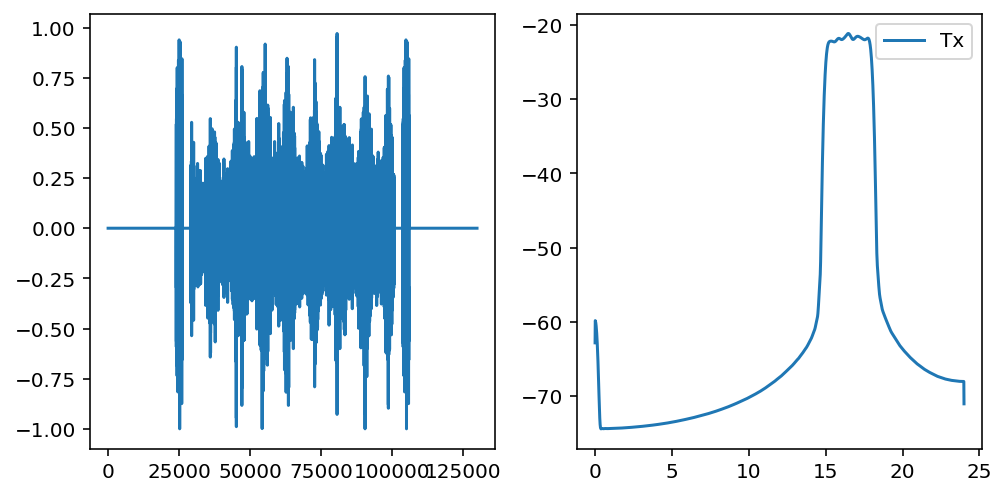

In [29]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot((s))
plt.subplot(122)
f, Pxx_den = sg.welch(s, fs, nfft=4096)
plt.plot(f / 1e3, 30 + 10 * np.log10(Pxx_den), color="C0", label="Tx")
plt.legend()

## Transmit through the air (or simulation)

In [30]:
!python -m pip install sounddevice

You should consider upgrading via the 'C:\Users\Giacomo\anaconda3\python.exe -m pip install --upgrade pip' command.


import sounddevice as sd
sd.query_devices()

In [37]:
import sounddevice as sd 
sd.query_devices()

>  0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
   1 Gruppo microfoni (Realtek(R) Au, MME (2 in, 0 out)
<  2 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
   3 Cassa/Cuffie (Realtek(R) Audio), MME (0 in, 2 out)
   4 Driver primario di acquisizione suoni, Windows DirectSound (2 in, 0 out)
   5 Gruppo microfoni (Realtek(R) Audio), Windows DirectSound (2 in, 0 out)
   6 Driver audio principale, Windows DirectSound (0 in, 2 out)
   7 Cassa/Cuffie (Realtek(R) Audio), Windows DirectSound (0 in, 2 out)
   8 Cassa/Cuffie (Realtek(R) Audio), Windows WASAPI (0 in, 2 out)
   9 Gruppo microfoni (Realtek(R) Audio), Windows WASAPI (2 in, 0 out)
  10 Cuffia auricolare (@System32\drivers\bthhfenum.sys,#2;%1 Hands-Free%0
;(Astéroïde)), Windows WDM-KS (0 in, 1 out)
  11 Cuffia auricolare (@System32\drivers\bthhfenum.sys,#2;%1 Hands-Free%0
;(Astéroïde)), Windows WDM-KS (1 in, 0 out)
  12 Speakers (Realtek HD Audio output with SST), Windows WDM-KS (0 in, 2 out)
  13 Gruppo microfoni 1 (Realtek

In [39]:
s = np.concatenate((np.zeros((int(0.5*fs)),), 0.4*s, np.zeros((int(0.5*fs)),)))
# r = s + 0.2 * np.random.randn(s.shape[0])

sd.default.samplerate = fs
sd.default.channels = 2

sd.default.device = 5
r = np.squeeze(sd.play(s, blocking=True))

sd.default.device = 7
rec = np.squeeze(sd.rec(r, blocking=True))

plt.figure()
f, Pxx_den = sg.welch(s, fs, nfft=4096)
plt.plot(f / 1e3, 30 + 10 * np.log10(Pxx_den), color="C0", label="Tx")
f, Pxx_den = sg.welch(r, fs, nfft=4096)
plt.plot(f / 1e3, 30 + 10 * np.log10(Pxx_den), color="C1", label="Rx")
plt.xlabel('Freq. [kHz]')
plt.ylabel('PSD [dB / Hz]')
plt.legend()

PortAudioError: Error opening OutputStream: Invalid number of channels [PaErrorCode -9998]

## Correlation to find the peaks

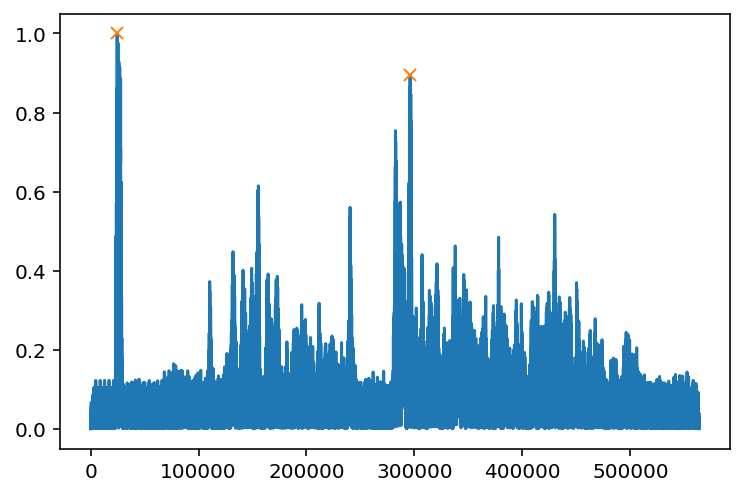

In [19]:
v_preamble = r * np.exp(-2 * np.pi * 1j * fc * np.arange(len(r)) / fs)
v_preamble = sg.convolve(v_preamble, rc_tx, mode="same")
xcorr = np.abs(sg.fftconvolve(v_preamble, preamble[::-1].conj()))
xcorr_norm = xcorr / xcorr.max()
peaks_rx, _ = sg.find_peaks(xcorr_norm, height=0.8, distance=ns_ofdm - 1000)

plt.figure()
plt.plot(xcorr_norm)
plt.plot(peaks_rx, xcorr_norm[peaks_rx], "x")

start = peaks_rx[0] + ns_pause
v_ofdm = r[start : start + ns_ofdm] * np.exp(
    -2 * np.pi * 1j * f0 * np.arange(ns_ofdm) / fs
)

## OFDM receiver

Text(0.5, 1.0, 'Error Pattern')

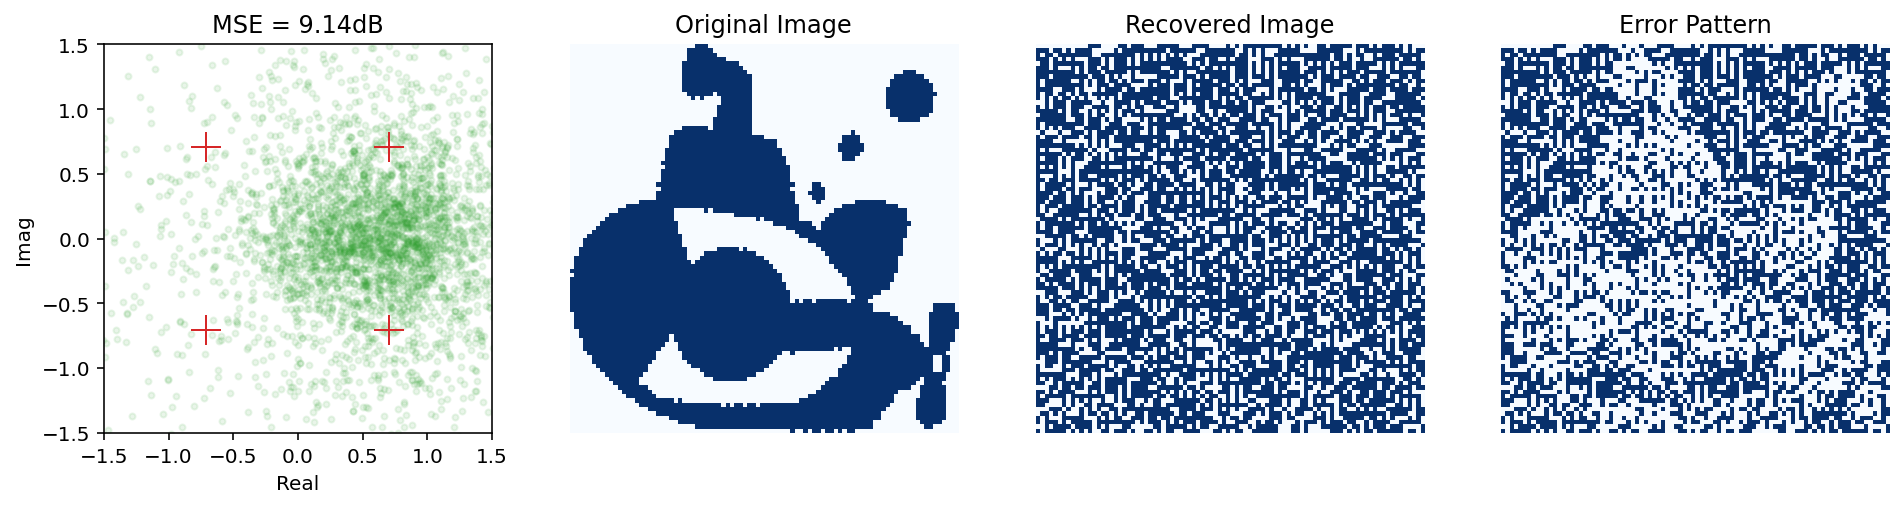

In [20]:
plt.figure(figsize=(16, 4))

mse = []
d_hat = np.zeros((K, n_blk), dtype=complex)
ax = plt.subplot(141)
for i_blk in range(n_blk):
    v_blk = v_ofdm[int(i_blk * Nb) : int((i_blk + 1) * Nb)]

    if is_cp:
        v_to_fft = v_blk[Ng:Nb]
    else:
        v_to_fft = v_blk
        v_to_fft[0:Ng, :] += v_to_fft[Ns : Ns + Ng]
    y_blk_all = Ns * np.fft.fft(v_to_fft, Ns, axis=0)
    y_blk = y_blk_all[0:K]

    h_blk = np.roll(y_blk, 1)
    d_hat[:, i_blk] = h_blk.conj() * y_blk / (h_blk.conj() * h_blk)
    d_hat[0, i_blk] = d[0, i_blk]  # pilots
    mse.append(np.mean(np.abs(d_hat[1:, i_blk] - d[1:, i_blk]) ** 2))
    plt.plot(d_hat[1:, i_blk].real, d_hat[1:, i_blk].imag, 'C2.', alpha=0.1)

plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.plot(alphabet.real, alphabet.imag, "C3+", markersize=15)
plt.title(f"MSE = {10*np.log10(np.mean(mse)):.2f}dB")
plt.xlabel("Real")
plt.ylabel("Imag")
plt.gca().set_aspect("equal", "box")

plt.subplot(142)
original = np.reshape(qpskdemod_bits(d.ravel())[0 : img_size[0] * img_size[1]], img_size)
plt.imshow(original, cmap=plt.cm.Blues)
plt.gca().set_axis_off()
plt.title("Original Image")

plt.subplot(143)
received = np.reshape(qpskdemod_bits(d_hat.ravel())[0 : img_size[0] * img_size[1]], img_size)
plt.imshow(received, cmap=plt.cm.Blues)
plt.gca().set_axis_off()
plt.title("Recovered Image")

plt.subplot(144)
plt.imshow(received!=original, cmap=plt.cm.Blues)
plt.gca().set_axis_off()
plt.title("Error Pattern")